<center><h1>Long Short-Term Memory Recurrent Neural Network</h1></center>

In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
import time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
numpy.random.seed(7)
plt.rcParams['figure.figsize'] = (10, 6)

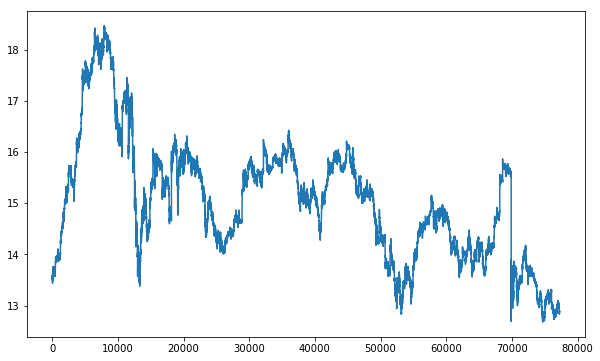

In [3]:
dataframe = pandas.read_csv('PETR4M1_LAST.csv', usecols=[4], engine='python', encoding='utf-16')
plt.plot(dataframe)
plt.show()

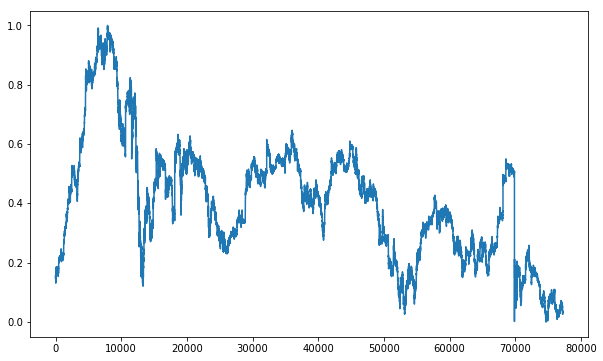

In [4]:
dataset = dataframe.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(dataset)
plt.plot(data_norm)
plt.show()

In [5]:
train_size = int(len(data_norm) * 0.65)
test_size = len(data_norm) - train_size
train, test = data_norm[0:train_size,:], data_norm[train_size:len(dataset),:]
print('Tamanho do conjunto de treino:', len(train))
print('Tamanho do conjunto de teste:', len(test))

Tamanho do conjunto de treino: 50217
Tamanho do conjunto de teste: 27041


In [6]:
def criar_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
exemplo_x, exemplo_y = criar_dataset(dataset, 1)
print(exemplo_x[:5,0])
print(exemplo_y[:5])

[ 13.57999992  13.56000042  13.52999973  13.52999973  13.52999973]
[ 13.56000042  13.52999973  13.52999973  13.52999973  13.52000046]


In [7]:
look_back = 1
trainX, trainY = criar_dataset(train, look_back)
testX, testY = criar_dataset(test, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
model = Sequential()
model.add(LSTM(6, input_shape=(1, look_back)))
model.add(Dense(1))
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=3, batch_size=1)
print('Tempo de processamento: %.2f segundos' % (time.time() - start))

Epoch 1/3
50215/50215 [==============================] - 65s - loss: 8.8370e-04    
Epoch 2/3
50215/50215 [==============================] - 64s - loss: 2.1520e-05    - ETA
Epoch 3/3
50215/50215 [==============================] - 69s - loss: 2.0200e-05    
Tempo de processamento: 200.21 segundos


In [9]:
trainPredict = model.predict(trainX)
trainY = [trainY]
testPredict = model.predict(testX)
testY = [testY]
trainREQM = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('REQM: %.4f para os dados de treino' % (trainREQM))
testREQM = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('REQM: %.4f para os dados de teste' % (testREQM))

REQM: 0.0041 para os dados de treino
REQM: 0.0060 para os dados de teste


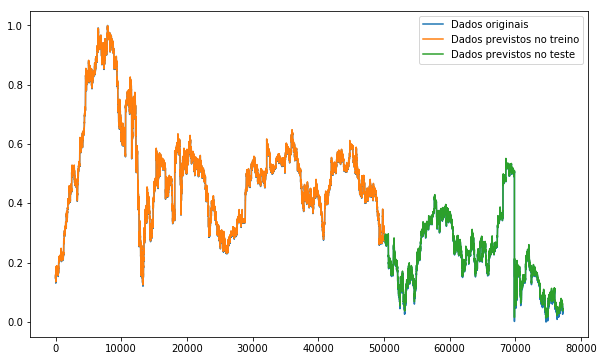

In [10]:
trainPredictPlot = numpy.empty_like(data_norm)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back-1:len(trainPredict)+look_back-1, :] = trainPredict
testPredictPlot = numpy.empty_like(data_norm)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(data_norm)-2, :] = testPredict
plt.plot(data_norm, label='Dados originais')
plt.plot(trainPredictPlot, label='Dados previstos no treino')
plt.plot(testPredictPlot, label='Dados previstos no teste')
plt.legend()
plt.show()

In [11]:
covmat = numpy.cov(testY[0][1:]-testY[0][:-1],testPredict[1:,0]-testPredict[:-1,0])
beta = covmat[0,1]/covmat[1,1]
print(beta)
covmat = numpy.cov(trainY[0][1:]-trainY[0][:-1],trainPredict[1:,0]-trainPredict[:-1,0])
beta = covmat[0,1]/covmat[1,1]
print(beta)

-0.123836995115
-0.0522263014837
